<a href="https://colab.research.google.com/github/joaoakio/The-Sun-and-the-Market/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sunspots & Equity Returns


**Objective:** Test whether monthly sunspot activity contains **incremental predictive information** for **next-month** S&P 500 returns **conditional on** standard financial predictors.

### Timing convention

Let $P_t^{EOM}$ be the S&P 500 level at **end of month** $t$. The forecasting target is the **next-month log return**:

$$
r_{t+1} \;=\; \log\!\left(P_{t+1}^{EOM}\right)\;-\;\log\!\left(P_{t}^{EOM}\right).
$$

All predictors are constructed so they are observable using information available at the **end of month $t$**, and they are used to forecast $r_{t+1}$. This **strict lag** is the key guardrail against look-ahead bias.

### Predictive regression

We compare **one standardized pair** of models throughout the notebook:

- **Model A (controls only):**
$$
r_{t+1} \;=\; \alpha \;+\; \sum_{i=1}^{N}\beta_i\,X_{i,t} \;+\; \varepsilon_{t+1}.
$$

- **Model B (controls + sunspots):**
$$
r_{t+1} \;=\; \alpha \;+\; \sum_{i=1}^{N}\beta_i\,X_{i,t} \;+\; \gamma\,SN_t \;+\; \varepsilon_{t+1}.
$$

Here $X_{1,t},\ldots,X_{N,t}$ are standard financial controls observed at $t$, $SN_t$ is the sunspot measure for month $t$, and $\gamma$ is the incremental contribution of sunspots **beyond** the controls.

### What “incremental value” means

Sunspots add value if including $SN_t$ **improves forecasting performance out-of-sample**, not merely if an in-sample $p$-value looks small. Therefore, the main decision criteria are **MSFE**, **OOS $R^2$**, and the **Clark–West** test, complemented by subsample/rolling stability checks.




In [29]:
# If you run this on a clean environment, this cell installs missing packages only.
import sys, subprocess, importlib

def ensure_import(module_name, pip_name=None):
    pip_name = pip_name or module_name
    try:
        return importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pip_name])
        return importlib.import_module(module_name)

# Core stack
ensure_import("numpy")
ensure_import("pandas")
ensure_import("matplotlib")
ensure_import("statsmodels")
ensure_import("scipy")

# Data source
ensure_import("yfinance")


<module 'yfinance' from '/usr/local/lib/python3.12/dist-packages/yfinance/__init__.py'>

In [30]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import statsmodels.api as sm
from scipy import stats

from IPython.display import display, Markdown


## 1) Data extraction and variable definitions

### Data sources

- **Yahoo Finance:** the S&P 500 index level (**^GSPC**) and standard market proxies used as controls (**^VIX**, **^TNX**, **^IRX**).
- **SILSO:** monthly sunspot counts, denoted $SN_t$.

### Timing convention

We work at **monthly end-of-month (EOM)** frequency. The target is the **next-month** S&P 500 log return, denoted $r_{t+1}$, measured from EOM $t$ to EOM $t+1$.  
All predictors are constructed so they are observable at **month $t$** and used to forecast **$r_{t+1}$** (i.e., information at $t$ → return realized at $t+1$). This strict lag structure avoids look-ahead bias by construction.

### Variables (controls and signal) and their tickers

| Variable | Definition (measured at $t$) | Source / proxy | Intuition (why it can matter for $r_{t+1}$) |
|---|---|---|---|
| `ret_m_l1` | previous-month log return $r_t$ | Yahoo Finance, derived from **^GSPC** | captures short-horizon dynamics (mild momentum/reversal) |
| `rv_m_l1` | realized volatility within month $t$ (from daily S&P 500 log returns) | Yahoo Finance, daily **^GSPC** | risk regime proxy; volatility clustering can affect next-month risk compensation |
| `vix_l1` | implied volatility level at EOM | Yahoo Finance **^VIX** | forward-looking uncertainty / risk appetite proxy |
| `tbill_l1` | short-rate proxy at EOM | Yahoo Finance **^IRX** (13-week T-bill) | cash/discount-rate environment; opportunity cost of risky assets |
| `term_slope_l1` | term slope at EOM: $(TNX_t-IRX_t)$ | Yahoo Finance **^TNX** (10y) and **^IRX** (3m) | yield curve slope proxy for macro regime / expectations |
| `sn_lag1` (i.e., $SN_t$) | monthly sunspots observed in month $t$ | SILSO monthly | candidate slow-moving proxy sometimes linked (in prior hypotheses) to attention/sentiment channels |

**Key question:** Conditional on the control set, does $SN_t$ add **incremental predictive information** for $r_{t+1}$, especially **out-of-sample**?



In [31]:
# --- Parameters
END = dt.date.today()
START = END - dt.timedelta(days=365 * 20 + 10)  # ~20 years

TICKER_SPX = "^GSPC"
TICKERS_CTRL = ["^VIX", "^TNX", "^IRX"]  # VIX, 10Y, 13W

# Pull daily data
tickers_all = [TICKER_SPX] + TICKERS_CTRL
raw = yf.download(
    tickers=tickers_all,
    start=str(START),
    end=str(END + dt.timedelta(days=1)),
    auto_adjust=False,
    progress=False,
    group_by="column",
)

# Helper: extract a single price series from yfinance output (handles MultiIndex)
def _extract_price(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        # Most common: level0=field, level1=ticker
        for field in ["Adj Close", "Close"]:
            if (field, ticker) in df.columns:
                s = df[(field, ticker)].copy()
                s.name = ticker
                return s
        # Alternative: level0=ticker, level1=field
        for field in ["Adj Close", "Close"]:
            if (ticker, field) in df.columns:
                s = df[(ticker, field)].copy()
                s.name = ticker
                return s
        raise KeyError(f"Could not find Close/Adj Close for {ticker} in yfinance download.")
    else:
        field = "Adj Close" if "Adj Close" in df.columns else "Close"
        s = df[field].copy()
        s.name = ticker
        return s

spx_px = _extract_price(raw, TICKER_SPX).dropna()
vix_px = _extract_price(raw, "^VIX").dropna()
tnx_px = _extract_price(raw, "^TNX").dropna()
irx_px = _extract_price(raw, "^IRX").dropna()

# Make sure indexes are DatetimeIndex and sorted
for s in [spx_px, vix_px, tnx_px, irx_px]:
    s.index = pd.to_datetime(s.index)
spx_px = spx_px.sort_index()
vix_px = vix_px.sort_index()
tnx_px = tnx_px.sort_index()
irx_px = irx_px.sort_index()

display(pd.DataFrame({"SPX": spx_px, "VIX": vix_px, "TNX": tnx_px, "IRX": irx_px}).tail())
print("Daily range:", spx_px.index.min().date(), "to", spx_px.index.max().date())


,SPX,VIX,TNX,IRX
Date,,,,
2025-12-15,6816.509766,16.500000,4.182,3.538
2025-12-16,6800.259766,16.480000,4.149,3.545
2025-12-17,6721.430176,17.620001,4.151,3.543
2025-12-18,6774.759766,16.870001,4.116,3.522
2025-12-19,NaN,16.420000,NaN,NaN


Daily range: 2005-12-14 to 2025-12-18


### 1.1) Sunspots (SILSO monthly mean total sunspot number)

We use the **monthly mean total sunspot number** from SILSO (Royal Observatory of Belgium).
This series is available from **1749-01 to the last elapsed month** (the most recent months may be **provisional**).

**What the file contains (per SILSO documentation):**
- `year`, `month`: calendar date
- `decimal_year`: decimal date for the middle of the month (informational)
- `sn`: monthly mean total sunspot number (simple mean of daily totals across the month)
- `sn_sd`: monthly standard deviation derived from daily inputs
- `n_obs`: number of daily observations used in that month
- `flag`: definitive/provisional marker (`*` = provisional; blank = definitive)

**Missing values**  
SILSO uses `-1` to indicate a missing monthly sunspot number, so we convert `sn = -1` to `NaN` and drop those rows.

**Timing**  
In our predictive setup, we treat sunspots as observed at month $t$ (the monthly value becomes known after the month ends) and use it to forecast **next-month** returns $r_{t+1}$.


In [32]:
# --- SILSO monthly mean total sunspot number (V2.0)
# Documentation highlights:
#   - Monthly mean total sunspot number (available from 1749-01)
#   - sn = -1 indicates missing
#   - flag: '*' = provisional, blank = definitive
# Columns (fixed-width positions): year, month, decimal_year, sn, sn_sd, n_obs, flag

import numpy as np
import pandas as pd
from pathlib import Path

SILSO_URL_TXT = "https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt"
SILSO_URL_CSV = "https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv"

def load_silso_monthly(source=SILSO_URL_TXT, prefer="txt"):
    """
    Load SILSO monthly mean total sunspot number (SN_m_tot_V2.0).

    Parameters
    ----------
    source : str or Path
        URL or local filepath.
    prefer : {"txt","csv"}
        Use TXT (fixed width) or CSV (semicolon separated).

    Returns
    -------
    DataFrame with columns:
        year, month, date, month_period, decimal_year, sn, sn_sd, n_obs, provisional
    """
    source = str(source)

    if prefer.lower() == "csv" or source.lower().endswith(".csv"):
        # CSV format: ';' separator; last column is 1 (definitive) / 0 (provisional)
        df = pd.read_csv(
            source,
            sep=";",
            header=None,
            names=["year","month","decimal_year","sn","sn_sd","n_obs","definitive"],
            comment="#",
            engine="python"
        )
        # Convert types
        for c in ["year","month","decimal_year","sn","sn_sd","n_obs","definitive"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df["provisional"] = (df["definitive"] == 0)
        df = df.drop(columns=["definitive"])

    else:
        # TXT format: fixed-width positions (per SILSO documentation)
        # character positions (1-indexed): [1-4] year, [6-7] month, [9-16] decimal,
        # [19-23] sn, [25-29] sd, [32-35] n_obs, [37] flag
        colspecs = [(0, 4), (5, 7), (8, 16), (18, 23), (24, 29), (31, 35), (36, 37)]
        df = pd.read_fwf(
            source,
            colspecs=colspecs,
            header=None,
            names=["year","month","decimal_year","sn","sn_sd","n_obs","flag"],
            comment="#"
        )

        # Numeric conversion
        for c in ["year","month","decimal_year","sn","sn_sd","n_obs"]:
            df[c] = pd.to_numeric(df[c], errors="coerce")

        # Flag: '*' means provisional; blank/NaN means definitive
        df["flag"] = df["flag"].astype(str).str.strip()
        df.loc[df["flag"].isin(["nan", "None"]), "flag"] = ""
        df["provisional"] = df["flag"].eq("*")

    # Build a clean monthly date and period key
    df["year"] = df["year"].astype("Int64")
    df["month"] = df["month"].astype("Int64")
    df["date"] = pd.to_datetime(
        df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-01",
        errors="coerce"
    )
    df["month_period"] = df["date"].dt.to_period("M")

    # Missing values: sn == -1 means missing (per SILSO doc)
    df.loc[df["sn"] == -1, "sn"] = np.nan

    # Final cleanup
    df = df.dropna(subset=["date","sn"]).sort_values("date").reset_index(drop=True)

    # Keep only the key columns (you can keep others if you prefer)
    df = df[["year","month","date","month_period","decimal_year","sn","sn_sd","n_obs","provisional"]]

    return df

sn = load_silso_monthly(SILSO_URL_TXT, prefer="txt")

display(sn.tail(12))
print("Sunspots months:", len(sn), "|", sn["date"].min().date(), "to", sn["date"].max().date())
print("Most recent months provisional?:", sn.tail(6)[["date","sn","provisional"]].to_string(index=False))



,year,month,date,month_period,decimal_year,sn,sn_sd,n_obs,provisional
3311,2024,12,2024-12-01,2024-12,2024.958,154.6,24.0,653,False
3312,2025,1,2025-01-01,2025-01,2025.042,137.0,23.1,772,False
3313,2025,2,2025-02-01,2025-02,2025.122,155.7,23.6,791,False
3314,2025,3,2025-03-01,2025-03,2025.204,134.2,20.9,1136,False
3315,2025,4,2025-04-01,2025-04,2025.286,141.4,17.7,1199,False
3316,2025,5,2025-05-01,2025-05,2025.371,78.5,10.9,1225,False
3317,2025,6,2025-06-01,2025-06,2025.453,114.6,15.0,1231,False
3318,2025,7,2025-07-01,2025-07,2025.538,125.6,16.9,1145,True
3319,2025,8,2025-08-01,2025-08,2025.623,133.5,18.2,1114,True
3320,2025,9,2025-09-01,2025-09,2025.705,129.8,15.4,961,True


Sunspots months: 3323 | 1749-01-01 to 2025-11-01
Most recent months provisional?:       date    sn  provisional
2025-06-01 114.6        False
2025-07-01 125.6         True
2025-08-01 133.5         True
2025-09-01 129.8         True
2025-10-01 114.6         True
2025-11-01  91.8         True


### 1.2) Monthly panel construction (strict lag)

We construct an **end-of-month (EOM)** monthly panel and enforce a **strict timing convention**.

- Each row in the panel is indexed by month **t** (end of month *t*).
- The **target** is the S&P 500 **next-month** log return, i.e., the return realized **from EOM(t) to EOM(t+1)**: this is $r_{t+1}$.
- All predictors are measured using information available **at EOM(t)** and are used to forecast $r_{t+1}$.

**Why this matters**  
This strict lag structure ensures that no information from month **t+1** (prices, volatility, rates, etc.) is used when forecasting the return that is realized in month **t+1**. In other words, the forecasting exercise is consistent with a real-time information set at EOM(t).



In [33]:
# --- EOM prices and monthly log returns
spx_eom = spx_px.resample("ME").last()
ret_m = np.log(spx_eom).diff()

panel = pd.DataFrame({"px_eom": spx_eom, "ret_m": ret_m}).dropna()
panel.index.name = "date_eom"
panel = panel.reset_index()
panel["month"] = panel["date_eom"].dt.to_period("M")

# --- Controls from Yahoo (EOM levels)
vix_eom = vix_px.resample("ME").last()
tnx_eom = tnx_px.resample("ME").last()
irx_eom = irx_px.resample("ME").last()

ctrl = pd.DataFrame({
    "month": vix_eom.index.to_period("M"),
    "vix_eom": vix_eom.values,
}).merge(
    pd.DataFrame({"month": tnx_eom.index.to_period("M"), "tnx_eom": tnx_eom.values}),
    on="month", how="outer"
).merge(
    pd.DataFrame({"month": irx_eom.index.to_period("M"), "irx_eom": irx_eom.values}),
    on="month", how="outer"
).sort_values("month").reset_index(drop=True)

# --- Realized volatility within month, from daily SPX log returns (robust)
ret_d = np.log(spx_px.squeeze()).diff().dropna()  # squeeze => garante Series

rv_m = (
    ret_d.groupby(ret_d.index.to_period("M"))
         .apply(lambda x: float(np.sqrt(np.sum((x.to_numpy())**2))))
         .reset_index()
)

# garante nomes exatos das colunas para o merge
rv_m.columns = ["month", "rv_m"]

# --- Merge controls into panel
panel = (
    panel.merge(ctrl, on="month", how="left")
         .merge(rv_m, on="month", how="left")
         .sort_values("month")
)

# --- Sunspots: map to month and build lagged predictor
sn_m = sn.copy()
sn_m["month"] = sn_m["date"].dt.to_period("M")
sn_m = sn_m[["month","sn"]].dropna()
panel = panel.merge(sn_m, on="month", how="left").sort_values("month").reset_index(drop=True)

# --- Strict lags (predictors at t-1)
panel["sn_lag1"] = panel["sn"].shift(1)
panel["ret_m_l1"] = panel["ret_m"].shift(1)
panel["rv_m_l1"] = panel["rv_m"].shift(1)

panel["vix_l1"] = panel["vix_eom"].shift(1)
panel["tbill_l1"] = panel["irx_eom"].shift(1)              # 13-week proxy
panel["term_slope_l1"] = (panel["tnx_eom"] - panel["irx_eom"]).shift(1)

controls = ["ret_m_l1", "rv_m_l1", "vix_l1", "tbill_l1", "term_slope_l1"]
sn_feat = "sn_lag1"

df = panel.dropna(subset=["ret_m"] + controls + [sn_feat]).copy().reset_index(drop=True)

display(df.head())
print("Monthly panel:", len(df), "|", df["month"].min(), "to", df["month"].max())
print("Controls:", controls)


,date_eom,px_eom,ret_m,month,vix_eom,tnx_eom,irx_eom,rv_m,sn,sn_lag1,ret_m_l1,rv_m_l1,vix_l1,tbill_l1,term_slope_l1
0,2006-02-28,1280.660034,0.000453,2006-02,12.340000,4.547,4.507,0.025469,5.7,20.9,0.025148,0.031236,12.950000,4.370,0.157
1,2006-03-31,1294.869995,0.011035,2006-03,11.390000,4.853,4.515,0.023280,17.3,5.7,0.000453,0.025469,12.340000,4.507,0.040
2,2006-04-30,1310.609985,0.012082,2006-04,11.590000,5.069,4.650,0.024239,50.3,17.3,0.011035,0.023280,11.390000,4.515,0.338
3,2006-05-31,1270.089966,-0.031405,2006-05,16.440001,5.113,4.715,0.036885,37.2,50.3,0.012082,0.024239,11.590000,4.650,0.419
4,2006-06-30,1270.199951,0.000087,2006-06,13.080000,5.138,4.860,0.045703,24.5,37.2,-0.031405,0.036885,16.440001,4.715,0.398


Monthly panel: 239 | 2006-02 to 2025-12
Controls: ['ret_m_l1', 'rv_m_l1', 'vix_l1', 'tbill_l1', 'term_slope_l1']


In [34]:
# Show the exact specification with the *current* controls list (no ambiguity)
controls_str = " + ".join([f"β_{i+1}·{c}" for i, c in enumerate(controls)])
spec = (
    "Model A (base): ret_m[t] = α + " + controls_str + " + ε_t\n\n"
    "Model B (aug):  ret_m[t] = α + " + controls_str + " + γ·" + sn_feat + " + ε_t"
)
display(Markdown("**Specification used below (plain text):**\n\n```\n" + spec + "\n```"))


**Specification used below (plain text):**

```
Model A (base): ret_m[t] = α + β_1·ret_m_l1 + β_2·rv_m_l1 + β_3·vix_l1 + β_4·tbill_l1 + β_5·term_slope_l1 + ε_t

Model B (aug):  ret_m[t] = α + β_1·ret_m_l1 + β_2·rv_m_l1 + β_3·vix_l1 + β_4·tbill_l1 + β_5·term_slope_l1 + γ·sn_lag1 + ε_t
```

## 2) Initial exploration

Before running any regressions, we do a **minimal diagnostic pass** to validate the panel construction and to form a first-order intuition about signal strength.

What we look at:
1. **Time-series overlays**: sunspots and S&P 500 monthly returns plotted over time.
   - Purpose: confirm the two series are on the same monthly calendar and that the sunspot series is not accidentally shifted forward/backward.
2. **Simple correlations**: contemporaneous association between monthly returns and the lagged sunspot measure used for forecasting.
   - Purpose: a coarse magnitude check (it should not be interpreted as causal evidence).
3. **Scatter plot (returns vs lagged sunspots)**:
   - Purpose: check whether any apparent relationship is driven by a few outliers or looks roughly linear.

These steps are **not** statistical evidence of predictability. They are a **sanity check** and an intuition-building step before formal in-sample and out-of-sample evaluation.


,ret_m,sn_lag1,ret_m_l1,rv_m_l1,vix_l1,tbill_l1,term_slope_l1
ret_m,1.000000,0.071576,0.032928,-0.041234,0.016180,0.007524,-0.076489
sn_lag1,0.071576,1.000000,0.077235,-0.155498,-0.227049,0.277619,-0.254020
ret_m_l1,0.032928,0.077235,1.000000,-0.454191,-0.482664,0.034329,-0.097491
rv_m_l1,-0.041234,-0.155498,-0.454191,1.000000,0.849419,-0.146838,0.176763
vix_l1,0.016180,-0.227049,-0.482664,0.849419,1.000000,-0.278545,0.289742
tbill_l1,0.007524,0.277619,0.034329,-0.146838,-0.278545,1.000000,-0.827270
term_slope_l1,-0.076489,-0.254020,-0.097491,0.176763,0.289742,-0.827270,1.000000


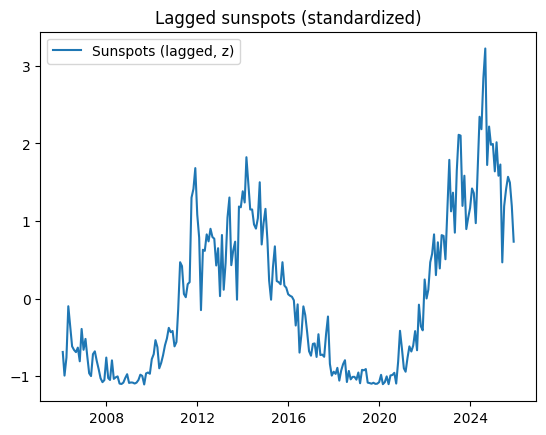

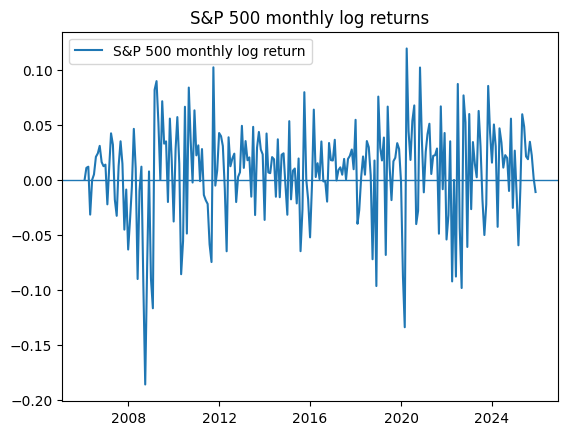

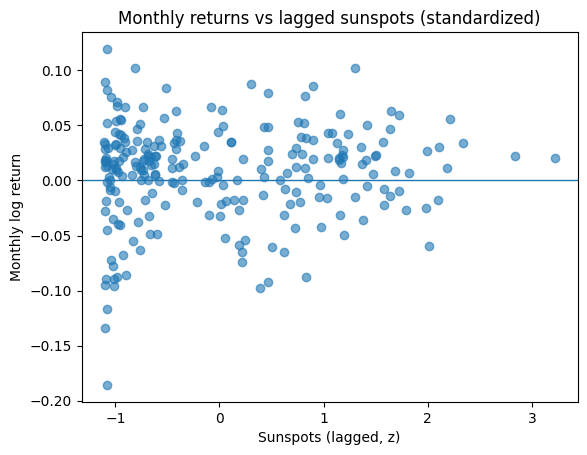

In [35]:
# Basic correlations (raw levels)
corr = df[["ret_m", sn_feat] + controls].corr()
display(corr)

# For plots / intuition, it helps to standardize sunspots to unit variance
sn_z = (df[sn_feat] - df[sn_feat].mean()) / df[sn_feat].std(ddof=0)

plt.figure()
plt.plot(df["month"].dt.to_timestamp(), sn_z, label="Sunspots (lagged, z)")
plt.title("Lagged sunspots (standardized)")
plt.legend()
plt.show()

plt.figure()
plt.plot(df["month"].dt.to_timestamp(), df["ret_m"], label="S&P 500 monthly log return")
plt.axhline(0, linewidth=1)
plt.title("S&P 500 monthly log returns")
plt.legend()
plt.show()

plt.figure()
plt.scatter(sn_z, df["ret_m"], alpha=0.6)
plt.axhline(0, linewidth=1)
plt.title("Monthly returns vs lagged sunspots (standardized)")
plt.xlabel("Sunspots (lagged, z)")
plt.ylabel("Monthly log return")
plt.show()



### 2.1) Results and interpretation (Initial Exploration)

This section is a **sanity check**, not an inferential test. The goal is to verify alignment (no look-ahead) and get a first-pass sense of signal strength.

**What we see in the correlations**
- The raw correlation between next-month equity returns and lagged sunspots is small:  
  $$\mathrm{corr}(r_{t+1}, SN_t) \approx 0.072.$$  
  At monthly frequency, a correlation of this magnitude is typically **weak** and easily dominated by noise.
- Sunspots co-move more with several controls than with returns (e.g., \(SN_t\) is correlated with the short-rate proxy and term slope, and negatively with VIX). This matters because it suggests **potential overlap/collinearity**: any apparent association between sunspots and returns could be proxying for broader macro/risk regimes unless we control for them.

**What we see in the time-series plots**
- Sunspots exhibit a **slow-moving cycle** (high persistence / low-frequency variation).
- Monthly equity returns are **high-variance and noisy** with no obvious low-frequency pattern that matches sunspots.
- This mismatch in “frequency content” is a first hint that sunspots may have limited forecasting power for monthly returns unless the effect is very strong (which is rare).

**What we see in the scatter plot**
- The cloud is widely dispersed with no clear functional shape, consistent with the small correlation above.
- Any “tilt” is visually minor relative to return dispersion, reinforcing the idea that if an effect exists, it is likely **economically small** and must be evaluated with formal controls and out-of-sample tests.

**Takeaway for the next sections**

These plots do **not** establish predictability. They mainly support the decision to:
1) rely on a controlled predictive regression with HAC/Newey–West errors, and  
2) prioritize **out-of-sample** performance (MSFE, OOS \(R^2\), Clark–West), because in-sample patterns at monthly frequency can be fragile and unstable.


## 3) In-sample predictive regression (nested models)

From this point onward we use **one nested pair** of predictive regressions consistently. The timing convention is:

- predictors are observed at the end of month $t$ (information set at $t$),
- the target is the **next-month** log return $r_{t+1}$.

In the code, `ret_m` corresponds to $r_{t+1}$ by construction (EOM-to-EOM return).

### Model definitions

**Model A (controls only):**
$$
r_{t+1} \;=\; \alpha \;+\; \sum_{j=1}^{N}\beta_j\,X_{j,t} \;+\; \varepsilon_{t+1}.
$$

**Model B (controls + sunspots):**
$$
r_{t+1} \;=\; \alpha \;+\; \sum_{j=1}^{N}\beta_j\,X_{j,t} \;+\; \gamma\,SN_t \;+\; \varepsilon_{t+1}.
$$

The parameter of interest is $\gamma$. It measures whether sunspot activity provides **incremental predictive information** once standard financial controls are included.

### Estimation details

We estimate both models by OLS and report **HAC / Newey–West** standard errors. This is appropriate here because monthly equity returns can be heteroskedastic and the regression residuals may exhibit mild serial correlation.

For interpretability, all predictors (controls and sunspots) are **standardized**:
a coefficient is the change in expected $r_{t+1}$ associated with a **one–standard deviation** move in the predictor.



In [36]:
# In-sample regressions with HAC (Newey–West)
# We standardize predictors for interpretability (unit = 1 std dev move).
preds = controls + [sn_feat]
df_is = df.copy()
for c in preds:
    mu = df_is[c].mean()
    sd = df_is[c].std(ddof=0)
    df_is[c + "_z"] = (df_is[c] - mu) / sd

controls_z = [c + "_z" for c in controls]
sn_z = sn_feat + "_z"

# Design matrices: Model A vs Model B (same pair used in OOS section)
X_A = sm.add_constant(df_is[controls_z], has_constant="add")
X_B = sm.add_constant(df_is[controls_z + [sn_z]], has_constant="add")

res_A = sm.OLS(df_is["ret_m"], X_A).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
res_B = sm.OLS(df_is["ret_m"], X_B).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

print("=== Model A (controls only) ===")
print(res_A.summary())

print("\n=== Model B (controls + sunspots) ===")
print(res_B.summary())

gamma = float(res_B.params[sn_z])
pval = float(res_B.pvalues[sn_z])
print(f"\nIncremental sunspot slope γ (Model B): {gamma:.4f} | HAC p-value: {pval:.3f}")


=== Model A (controls only) ===
                            OLS Regression Results                            
Dep. Variable:                  ret_m   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                    0.8334
Date:                Fri, 19 Dec 2025   Prob (F-statistic):              0.527
Time:                        12:53:49   Log-Likelihood:                 411.22
No. Observations:                 239   AIC:                            -810.4
Df Residuals:                     233   BIC:                            -789.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const     

### 3.1) Results and interpretation (In-sample)

**Controls-only benchmark (Model A)**  
The controls explain a small fraction of monthly return variation (in-sample $R^2 \approx 0.029$). This is expected: monthly equity returns are noisy, and short-horizon predictability is typically weak.

**Incremental sunspot effect (Model B)**  
Adding sunspots increases the in-sample fit only marginally ($R^2 \approx 0.035$). The estimated sunspot slope is:

$$
\hat{\gamma} \approx 0.0036 \quad \text{(sunspots standardized)}
$$

with HAC p-value $\approx 0.124$. Interpreting magnitudes: a one–standard deviation increase in lagged sunspots is associated with about **+0.36%** in expected next-month log return, but the estimate is **not statistically robust** at conventional 5% levels under HAC.

**What this means (in-sample)**
- The point estimate is **positive**, but evidence is **weak**: we cannot reject $\gamma = 0$ at standard significance thresholds.
- The small change in $R^2$ indicates that, even if the relationship exists, it is likely **economically modest** relative to monthly return volatility.

**In-sample takeaway**  
At this stage, sunspots look like an **interesting but fragile** feature: the sign is positive, but statistical support is limited. This motivates the next steps: (i) stability checks across subsamples/rolling windows, and (ii) an out-of-sample forecasting comparison (MSFE, OOS $R^2$, Clark–West), which is the main criterion for “incremental value” in a forecasting context.


## 4) Stability check: does the sunspot slope persist?

A single in-sample estimate can be misleading: even if the sunspot coefficient is positive on average, a usable predictive relationship should be at least **directionally stable** across time. Here we ask whether the incremental sunspot slope in **Model B** is reasonably stable across market regimes.

### What we do

1. **Coarse subsample split (first vs second half)**  
   We re-estimate Model B on two broad eras. If the sign or magnitude of the sunspot slope changes materially, that is immediate evidence of instability.

2. **Rolling-window estimates (10 years = 120 months)**  
   We estimate Model B on a moving window of 120 months and track:
   - the rolling sunspot slope, $\hat\gamma_t,$
   - the rolling HAC p-value for $H_0:\gamma=0.$

This is not a formal structural-break test; it is a transparent diagnostic that shows whether the relationship is **persistent** or **episodic**.



,sample,gamma (SN),pvalue (HAC),n_months
0,first_half,0.009901,0.082413,119
1,second_half,-0.001144,0.858996,120


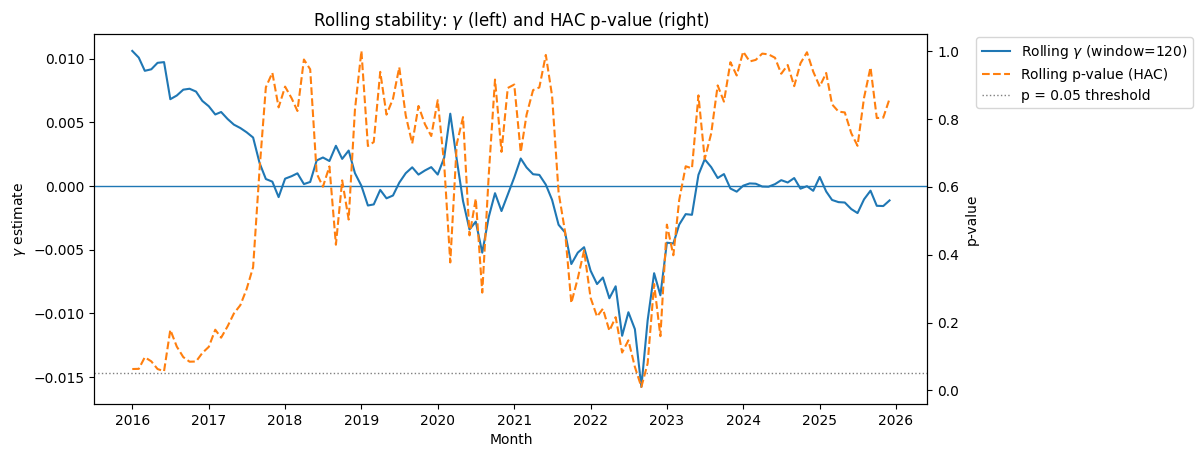

In [37]:
# --- Stability check: first/second half + rolling gamma AND rolling p-value (Model B)

# --- Helper: robustly coerce controls/sn identifiers into column name strings
def _as_colnames(cols):
    out = []
    for c in cols:
        if isinstance(c, pd.Series):
            if c.name is None:
                raise ValueError("A predictor Series has no name; please ensure it comes from df[col].")
            out.append(c.name)
        else:
            out.append(str(c))
    return out

# Expect these to exist from the in-sample section:
#   df_is       : DataFrame with at least ["month","ret_m", controls_z..., sn_z]
#   controls_z  : list of standardized control columns (names OR Series)
#   sn_z        : standardized sunspot column (name OR Series)
controls_cols = _as_colnames(controls_z)
sn_col = _as_colnames([sn_z])[0]

# --- Keep only rows needed for Model B
need = ["ret_m", "month"] + controls_cols + [sn_col]
df_stab = df_is.dropna(subset=need).copy()

# Ensure month is Period[M]
if not isinstance(df_stab["month"].dtype, pd.PeriodDtype):
    df_stab["month"] = pd.to_datetime(df_stab["month"]).dt.to_period("M")

df_stab = df_stab.sort_values("month").reset_index(drop=True)

def fit_model_b(df_sub, hac_lags=3):
    X = sm.add_constant(df_sub[controls_cols + [sn_col]], has_constant="add")
    return sm.OLS(df_sub["ret_m"], X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

# --- (A) First vs second half
mid = len(df_stab) // 2
df_first = df_stab.iloc[:mid].copy()
df_second = df_stab.iloc[mid:].copy()

res_first = fit_model_b(df_first, hac_lags=3)
res_second = fit_model_b(df_second, hac_lags=3)

tab_half = pd.DataFrame({
    "sample": ["first_half", "second_half"],
    "gamma (SN)": [float(res_first.params[sn_col]), float(res_second.params[sn_col])],
    "pvalue (HAC)": [float(res_first.pvalues[sn_col]), float(res_second.pvalues[sn_col])],
    "n_months": [len(df_first), len(df_second)],
})
display(tab_half)

# --- (B) Rolling window: gamma + HAC p-value
window = 120
hac_lags = 3

roll_end_month = []
roll_gamma = []
roll_p = []

for end in range(window, len(df_stab) + 1):
    sub = df_stab.iloc[end - window:end]
    rr = fit_model_b(sub, hac_lags=hac_lags)
    roll_end_month.append(sub["month"].iloc[-1])
    roll_gamma.append(float(rr.params[sn_col]))
    roll_p.append(float(rr.pvalues[sn_col]))

roll = pd.DataFrame({
    "month": roll_end_month,
    "gamma": roll_gamma,
    "pval": roll_p,
}).dropna()

# --- Plot: stretched + gamma and p-value (secondary axis), legend fully outside

fig, ax1 = plt.subplots(figsize=(14, 4.8))

# Left axis: rolling gamma (choose a color explicitly)
h1, = ax1.plot(
    roll["month"].dt.to_timestamp(),
    roll["gamma"],
    label=rf"Rolling $\gamma$ (window={window})",
    color="tab:blue",
)
ax1.axhline(0, linewidth=1)
ax1.set_xlabel("Month")
ax1.set_ylabel(r"$\gamma$ estimate")
ax1.set_title(r"Rolling stability: $\gamma$ (left) and HAC p-value (right)")

# Right axis: rolling p-value (different color)
ax2 = ax1.twinx()
h2, = ax2.plot(
    roll["month"].dt.to_timestamp(),
    roll["pval"],
    label="Rolling p-value (HAC)",
    linestyle="--",
    color="tab:orange",
)
h3 = ax2.axhline(0.05, linewidth=1, linestyle=":", color="tab:gray")
ax2.set_ylabel("p-value")

# Reserve a wider right margin for the legend (so it won't overlap right y-axis ticks)
fig.subplots_adjust(right=0.72)

# Put ONE legend at figure-level, inside the reserved margin
handles = [h1, h2, h3]
labels = [h1.get_label(), h2.get_label(), "p = 0.05 threshold"]
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(0.75, 0.8),
    frameon=True,
)

plt.show()



### 4.1) Results and interpretation (Stability)

**First vs second half**  
The coarse split already suggests instability:

- First half: $\hat\gamma \approx 0.0099$ (HAC p-value $\approx 0.082$, $n=119$)
- Second half: $\hat\gamma \approx -0.0011$ (HAC p-value $\approx 0.859$, $n=120$)

So the estimated sunspot effect flips from **positive** to essentially **zero/negative** and clearly insignificant.

**Rolling-window view (120 months)**  
The rolling estimates reinforce the same point: $\hat\gamma_t$ varies substantially through time and the HAC p-values are typically **well above** 0.05. There is a short episode where $\hat\gamma_t$ becomes strongly negative (around 2022–2023) with a lower p-value, but this does not look like a stable, persistent relationship.

**Stability takeaway**  
Even if the full-sample in-sample coefficient is positive, the relationship is **not stable** across eras/windows. This is a key reason to treat sunspots as an **exploratory feature** rather than a reliable standalone predictor. This motivates placing more weight on the **out-of-sample** forecast comparison (MSFE, OOS $R^2$, Clark–West), which directly measures incremental forecasting value under realistic timing.


## 5) Out-of-sample (OOS) forecasting test

An in-sample estimate of $\gamma$ can look “interesting” even when it does not translate into usable predictability. The practical question is whether adding sunspots improves **one-step-ahead forecast accuracy** for the next-month return $r_{t+1}$ on data that were not used to estimate the model.

We therefore compare the same nested pair used in-sample:

- **Model A (base):** controls only  
- **Model B (augmented):** controls + sunspots

### Procedure (expanding-window, one-step-ahead)
1. Choose an initial training window of `min_train` months.
2. For each forecast origin $t$:
   - Fit Model A and Model B using data available up to month $t$ (expanding window).
   - Produce one-step-ahead forecasts $\hat r^{A}_{t+1}$ and $\hat r^{B}_{t+1}$.
3. Evaluate forecast performance over the OOS period:
   - **MSFE** (mean squared forecast error) for each model.
   - **Out-of-sample $R^2$**:
     $$
     R^2_{\text{OOS}} = 1 - \frac{\text{MSFE}_B}{\text{MSFE}_A}.
     $$
     Values above zero mean the augmented model improves forecast accuracy relative to controls alone; values below zero mean it performs worse.
4. Apply the **Clark–West** test (with HAC/Newey–West standard errors) to account for the fact that Model B is a **nested** extension of Model A, and to test whether any incremental OOS improvement is statistically meaningful.

**Implementation detail (important):** predictors are standardized **within each training window** only. This prevents information leakage from the test period into the model fit.



OOS months: 179
MSFE (base): 0.0020155582996662933
MSFE (aug) : 0.0020607517266718824
OOS R^2    : -0.02242228717128736
Clark–West (HAC): t=0.638 | one-sided p≈0.262


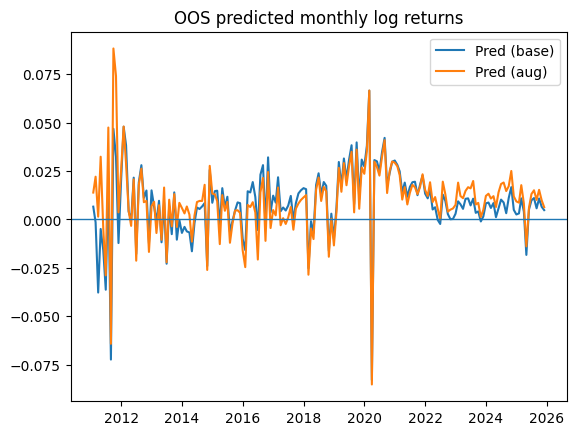

In [38]:
def _design(df_, cols):
    X = df_[cols].copy() if cols else pd.DataFrame(index=df_.index)
    X = sm.add_constant(X, has_constant="add")
    return X

def _standardize_train_test(train_df, test_df, cols):
    train = train_df.copy()
    test = test_df.copy()
    for c in cols:
        mu = train[c].mean()
        sd = train[c].std(ddof=0)
        if (sd is None) or (sd == 0) or np.isnan(sd):
            train[c] = 0.0
            test[c] = 0.0
        else:
            train[c] = (train[c] - mu) / sd
            test[c] = (test[c] - mu) / sd
    return train, test

def expanding_forecast_compare(dfin, y, base_cols, aug_cols, min_train=60, hac_lags=3):
    d = dfin.dropna(subset=[y] + list(set(aug_cols))).reset_index(drop=True)

    pred_b = [np.nan] * len(d)
    pred_a = [np.nan] * len(d)

    for t in range(min_train, len(d)):
        train = d.iloc[:t].copy()
        test = d.iloc[t:t+1].copy()

        # Standardize predictors using TRAIN window only (prevents leakage)
        train_s, test_s = _standardize_train_test(train, test, aug_cols)

        # Base model
        Xb_tr = _design(train_s, base_cols)
        rb = sm.OLS(train_s[y], Xb_tr).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
        Xb_te = _design(test_s, base_cols)
        pred_b[t] = float(rb.predict(Xb_te).iloc[0])

        # Augmented model
        Xa_tr = _design(train_s, aug_cols)
        ra = sm.OLS(train_s[y], Xa_tr).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
        Xa_te = _design(test_s, aug_cols)
        pred_a[t] = float(ra.predict(Xa_te).iloc[0])

    out = d.copy()
    out["pred_base"] = pred_b
    out["pred_aug"] = pred_a
    out = out.dropna(subset=["pred_base", "pred_aug"]).reset_index(drop=True)

    e_b = out[y] - out["pred_base"]
    e_a = out[y] - out["pred_aug"]

    msfe_b = float(np.mean(e_b**2))
    msfe_a = float(np.mean(e_a**2))
    oos_r2 = float(1.0 - msfe_a / msfe_b)

    return out, msfe_b, msfe_a, oos_r2

base_cols = controls[:]                # controls only
aug_cols = controls[:] + [sn_feat]     # controls + sunspots

oos_df, msfe_b, msfe_a, oos_r2 = expanding_forecast_compare(
    df, y="ret_m", base_cols=base_cols, aug_cols=aug_cols, min_train=60, hac_lags=3
)

print("OOS months:", len(oos_df))
print("MSFE (base):", msfe_b)
print("MSFE (aug) :", msfe_a)
print("OOS R^2    :", oos_r2)

# Clark–West adjustment (nested models)
cw = (oos_df["ret_m"] - oos_df["pred_base"])**2 - (
    (oos_df["ret_m"] - oos_df["pred_aug"])**2 - (oos_df["pred_base"] - oos_df["pred_aug"])**2
)
cw_res = sm.OLS(cw, np.ones(len(cw))).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

cw_t = float(cw_res.tvalues.iloc[0])
cw_p_one = float(cw_res.pvalues.iloc[0] / 2.0)  # one-sided approx (CW is usually one-sided)
print(f"Clark–West (HAC): t={cw_t:.3f} | one-sided p≈{cw_p_one:.3f}")

plt.figure()
plt.plot(oos_df["month"].dt.to_timestamp(), oos_df["pred_base"], label="Pred (base)")
plt.plot(oos_df["month"].dt.to_timestamp(), oos_df["pred_aug"], label="Pred (aug)")
plt.axhline(0, linewidth=1)
plt.title("OOS predicted monthly log returns")
plt.legend()
plt.show()


### 5.1) Results and interpretation (OOS)

Over the OOS evaluation window (179 months), the augmented model does **not** improve forecast accuracy:

- $\text{MSFE}_A \approx 0.002015$ (controls only)
- $\text{MSFE}_B \approx 0.002060$ (controls + sunspots)
- $R^2_{\text{OOS}} \approx -0.022$

A negative $R^2_{\text{OOS}}$ means that, in this setup, adding sunspots slightly **worsens** mean squared forecast performance relative to the controls-only benchmark.

The Clark–West statistic is also not supportive:
- Clark–West (HAC): $t \approx 0.638$, one-sided $p \approx 0.262$

So we do not reject the null that the augmented model fails to deliver incremental predictive value out of sample.

**Visual read of the forecast series**  
The predicted return paths for the base and augmented models move closely together, with no consistent separation that would suggest a stable incremental signal from sunspots. Any differences appear episodic rather than persistent.

**OOS takeaway**  
Even if $\hat\gamma$ is positive in-sample, the OOS evidence indicates that sunspots do not add reliable incremental forecasting power beyond standard controls (under an expanding-window, one-step-ahead evaluation).


## 6) Allocation strategy simulation (monthly, investable lens)

This section translates the **out-of-sample (OOS)** forecasts from the **augmented model** (controls + sunspots) into a deliberately simple **monthly** allocation rule. The goal is **not** to engineer a trading strategy, but to answer a basic question:

> **Is the incremental forecast content strong enough to show up under a minimal, investable implementation?**

### Timing and alignment (strict $t \rightarrow t+1$, no look-ahead)

The dataset is built with a **strict lag structure**:

- At the **end of month $t$** we observe predictors $\{X_t, SN_t\}$.
- Using only information available at **$t$**, the model produces a one-step-ahead forecast  
  $$\hat r_{t+1\mid t}.$$
- The realized return is earned **during month $t+1$**:
  $$r_{t+1} = \log\!\left(P^{EOM}_{t+1}\right) - \log\!\left(P^{EOM}_{t}\right).$$

In the OOS table, each row is indexed by the **realized-return month** ($t+1$). For clarity we also compute a `decision_month = (t+1) - 1 = t`.

### From forecasts to positions

We apply a simple sign rule:

- Go **long** the index if the forecast is positive:
  $$pos_t = \mathbf{1}\{\hat r_{t+1\mid t} > 0\}.$$
- Otherwise stay in **cash** (0 exposure).

The strategy log return earned in month $t+1$ is:
$$r^{strat}_{t+1} = pos_t \cdot r_{t+1}.$$

### Performance visualization (wealth curve)

Because we work with **log returns**, cumulative performance is naturally additive. We convert cumulative log returns to a wealth index (starting at 1) via:
$$W_{t} = \exp\!\left(\sum_{\tau \le t} r_\tau\right).$$

We plot both:
- a **wealth curve** $W_t$ (level, start = 1), and
- a **cumulative simple return (%)** for readability: $100\cdot(W_t-1)$.







Strategy (OOS, monthly): {'ann_mean_log': 0.09509169294277937, 'ann_vol_log': 0.12864270067980293, 'sharpe': 0.7391922933852778}
Buy&Hold (OOS)        : {'ann_mean_log': 0.11139043420733011, 'ann_vol_log': 0.1407537801810116, 'sharpe': 0.7913850275572013}


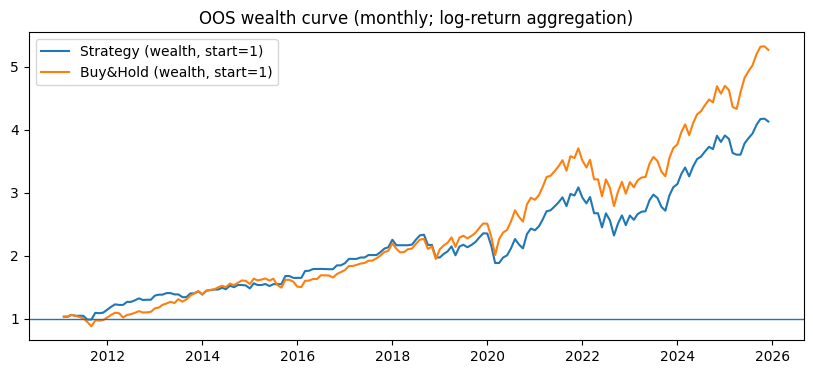

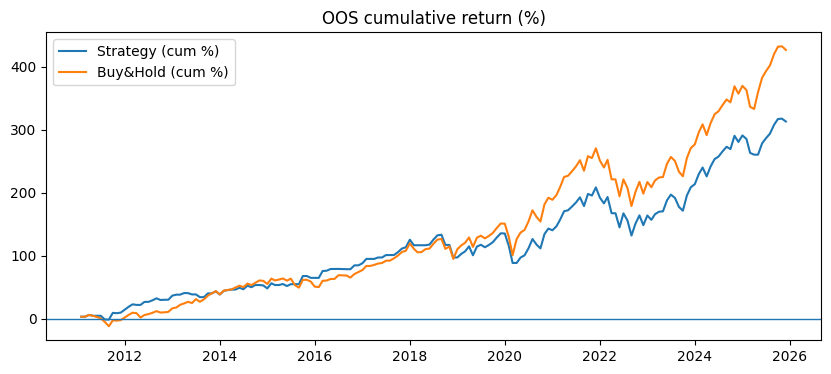

,decision_month,month,ret_m,pred_aug,pos
0,2011-01,2011-02,0.031457,0.013852,1.0
1,2011-02,2011-03,-0.001048,0.022039,1.0
2,2011-03,2011-04,0.028097,0.001407,1.0
3,2011-04,2011-05,-0.013593,0.032352,1.0
4,2011-05,2011-06,-0.018426,-0.004539,0.0
5,2011-06,2011-07,-0.021708,-0.028878,0.0
6,2011-07,2011-08,-0.058468,0.047411,1.0
7,2011-08,2011-09,-0.074467,-0.064176,0.0
8,2011-09,2011-10,0.102307,0.088205,1.0
9,2011-10,2011-11,-0.005072,0.073973,1.0


In [39]:
# --- 6) Allocation / strategy simulation (monthly, no look-ahead)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ann_stats_logret(x_log):
    """
    Annualized summary stats for monthly *log returns*.
    - ann_mean_log: 12 * mean(log return)
    - ann_vol_log : sqrt(12) * std(log return)
    - sharpe      : ann_mean_log / ann_vol_log
    """
    x = pd.Series(x_log).dropna()
    mean_m = x.mean()
    vol_m  = x.std(ddof=1)

    ann_mean = float(mean_m * 12.0)
    ann_vol  = float(vol_m * np.sqrt(12.0))
    sharpe   = np.nan if ann_vol == 0 else float(ann_mean / ann_vol)

    return {"ann_mean_log": ann_mean, "ann_vol_log": ann_vol, "sharpe": sharpe}

# Alignment note:
# Each row is labeled by 'month' = the realized-return month.
# Because predictors are strictly lagged, pred_aug for a row uses only information
# available by the end of the previous month.
bt = oos_df.copy()
bt["decision_month"] = (bt["month"] - 1).astype("period[M]")

# Position decided at end of decision_month, held through 'month'
bt["pos"] = (bt["pred_aug"] > 0).astype(float)

# Strategy return earned over 'month'
bt["strat_ret"] = bt["pos"] * bt["ret_m"]

# Wealth (start at 1): with log returns, wealth = exp(cumsum(logret))
bt["wealth_strat"] = np.exp(bt["strat_ret"].cumsum())
bt["wealth_bh"]    = np.exp(bt["ret_m"].cumsum())

# Cumulative simple returns (%) for readability
bt["cumret_strat_pct"] = 100.0 * (bt["wealth_strat"] - 1.0)
bt["cumret_bh_pct"]    = 100.0 * (bt["wealth_bh"] - 1.0)

# Print performance stats
stats_strat = ann_stats_logret(bt["strat_ret"])
stats_bh    = ann_stats_logret(bt["ret_m"])

print("Strategy (OOS, monthly):", stats_strat)
print("Buy&Hold (OOS)        :", stats_bh)

# Wealth curve
plt.figure(figsize=(10, 4))
plt.plot(bt["month"].dt.to_timestamp(), bt["wealth_strat"], label="Strategy (wealth, start=1)")
plt.plot(bt["month"].dt.to_timestamp(), bt["wealth_bh"],    label="Buy&Hold (wealth, start=1)")
plt.title("OOS wealth curve (monthly; log-return aggregation)")
plt.axhline(1.0, linewidth=1)
plt.legend()
plt.show()

# Cumulative return (%) curve
plt.figure(figsize=(10, 4))
plt.plot(bt["month"].dt.to_timestamp(), bt["cumret_strat_pct"], label="Strategy (cum %)")
plt.plot(bt["month"].dt.to_timestamp(), bt["cumret_bh_pct"],    label="Buy&Hold (cum %)")
plt.title("OOS cumulative return (%)")
plt.axhline(0.0, linewidth=1)
plt.legend()
plt.show()

display(bt[["decision_month", "month", "ret_m", "pred_aug", "pos"]].head(10))



### 6.1) Results and interpretation (Allocation strategy)

- Translating the augmented OOS forecasts into a monthly “long vs cash” rule does not beat buy-and-hold in this sample.
- This matches the negative OOS $R^2$: if forecasts are not better, a simple strategy built on them is unlikely to dominate.
- Interpretation: under a minimal investable rule, the sunspot-augmented signal does not add economic value.


## 7) Executive summary

### What we asked
We tested whether **monthly sunspot activity** contains **incremental predictive information** for **next-month S&P 500 returns**, **conditional on** a standard set of financial controls. The core question is whether adding sunspots improves forecasting performance beyond what is already captured by typical market predictors.

### What we did (high-level)
- Built a **monthly end-of-month (EOM)** panel with a **strict $t \rightarrow t+1$ timing**: predictors observed at month $t$ forecast the return $r_{t+1}$.
- Estimated a **nested pair** of predictive regressions:
  - **Model A:** controls only
  - **Model B:** controls + sunspots
- Used **HAC / Newey–West** standard errors in-sample.
- Evaluated **forecast value out-of-sample (OOS)** using an **expanding window**, **MSFE**, **OOS $R^2$**, and a **Clark–West** test (nested-model adjustment).
- Translated OOS forecasts into a **simple monthly allocation rule** (long if forecast $>0$, else cash) to check whether the signal survives a minimal “investable lens”.


---

## Main findings

### 1) Initial exploration: weak unconditional relationship
Simple correlations and scatter plots show **no strong unconditional relationship** between lagged sunspots and monthly equity returns. Any association appears **small relative to return noise**, which is what we expect for monthly equity returns.

### 2) In-sample regressions: $\gamma$ is positive but not statistically robust
In the augmented model (controls + sunspots), the estimated sunspot slope $\gamma$ is **positive**, but its **HAC p-value is above conventional 5% thresholds**. Interpreting this literally:

- The data are consistent with **a small positive association**, but
- we do **not** have strong statistical evidence that sunspots add reliable incremental predictive content once controls are included.

### 3) Stability: the sunspot effect is not persistent through time
Subsample and rolling-window estimates show that $\gamma$ is **not stable**:
- the sign/magnitude changes across eras,
- and rolling HAC p-values are typically **not supportive**.

This instability matters because a predictive feature that is not persistent is unlikely to generalize and is more compatible with **noise, regime dependence, or data-mining risk** than with a durable signal.

### 4) Out-of-sample forecasting: adding sunspots does not improve accuracy
The OOS test directly addresses the practical question. Results indicate:
- **MSFE increases** when sunspots are added,
- **OOS $R^2$ is negative**, meaning the augmented model forecasts worse than controls-only,
- the **Clark–West test** is not supportive of incremental predictive value.

Taken together: even if the in-sample coefficient is mildly positive, sunspots do **not** deliver incremental forecast performance when evaluated under a clean, expanding-window OOS protocol.

### 5) Allocation simulation: no economic value in a minimal implementation
Using the augmented model’s OOS forecasts to drive a monthly long/cash rule:
- the strategy **underperforms Buy & Hold** in the same OOS window (lower annualized mean log return and lower Sharpe).

This is consistent with the negative OOS $R^2$: if the forecasts do not improve accuracy, they typically will not produce a stronger allocation rule either.

---

## Practical interpretation
Based on the evidence:

1. **Sunspots should not be treated as a standalone signal** for allocating meaningful capital.
2. As an incremental feature, sunspots appear **weak, unstable, and not OOS-valuable** in this implementation.
3. The most defensible stance is: **sunspots are exploratory at best**, and any claim of predictive power requires substantially more robustness work.

---

## Key assumptions and limitations to acknowledge
- **Data source quality:** Yahoo Finance is acceptable for prototyping, but production-grade work should use a vetted market data feed.
- **Low signal-to-noise:** monthly equity returns are extremely noisy; small coefficients can appear in-sample by chance.
- **Multiple testing risk:** many “exogenous/sentiment” proxies exist; without pre-registered hypotheses, false positives are likely.
- **Model class:** linear predictive regressions may miss nonlinearities, but the OOS result suggests limited value even in a simple setting.

---

## Bottom line
**Within this dataset, model class, and evaluation design, sunspots do not provide incremental predictive or economic value for next-month S&P 500 returns beyond standard controls.**

